In [ ]:
!pip install datasets  # huggingface library with dataset
!pip install conllu    # aux library for processing CoNLL-U format

!pip install transformers
!pip install datasets
!pip install evaluate
!pip install accelerate

!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 14.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/cola

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from functools import partial
from datasets import load_dataset
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Arc-Eager and Oracle

The `ArcEager` class implements the Arc-Eager parser through the definition of the four transition operators:


*   *LeftArc*: pop the top-most stack element and attach it as a dependent of the first element of the buffer
*   *RightArc*: attach the first element of the buffer as a dependent of the top-most stack element and shift the first buffer element into the stack
* *Reduce*: pop the stack
* *Shift*: remove the first element of the buffer and push it into the stack

The check of the preconditions for the *Left Arc* and *Reduce* operations are included. Also, we consider trees final when any configuration of the form c = (Σ, [ ]) is reached, where Σ can be any subset of the stack, according to the reference [article](https://aclanthology.org/C12-1059/).


The class `Oracle` implements a static oracle that is able to produce training instances for our models: given a gold tree, it returns a transition operator.

In [ ]:
class ArcEager:
  def __init__(self, sentence):
    self.sentence = sentence
    self.buffer = [i for i in range(len(self.sentence))]
    self.stack = []
    self.arcs = [-1 for _ in range(len(self.sentence))]

    # one shift move to initialize the stack
    self.shift()

  def shift(self):
    b1 = self.buffer.pop(0)
    self.stack.append(b1)

  def left_arc(self):
    s1 = self.stack[-1]
    b1 = self.buffer[0]
    if s1 != 0 and self.arcs[s1] == -1:
      self.stack.pop()
      self.arcs[s1] = b1
      return True
    else:
      return False

  def right_arc(self):
    s1 = self.stack[-1]
    b1 = self.buffer.pop(0)
    self.arcs[b1] = s1
    self.stack.append(b1)

  def reduce(self):
    s1 = self.stack[-1]

    if self.arcs[s1] != -1:
      self.stack.pop()
      return True
    else:
      return False

  def is_tree_final(self):
    return len(self.buffer) == 0

  def print_configuration(self):
    s = [self.sentence[i] for i in self.stack]
    b = [self.sentence[i] for i in self.buffer]
    print(s, b)
    print(self.arcs)

In [ ]:
class Oracle:
  def __init__(self, parser, gold_tree):
    self.parser = parser
    self.gold = gold_tree

  def is_left_arc_gold(self):
    s1 = self.parser.stack[-1]
    b1 = self.parser.buffer[0]

    if self.gold[s1] == b1:
      return True

    return False

  def is_right_arc_gold(self):
    s1 = self.parser.stack[-1]
    b1 = self.parser.buffer[0]

    if self.gold[b1] == s1:
      return True

    return False


  def is_reduce_gold(self):
    b1 = self.parser.buffer[0]

    for k in self.parser.stack[:-1]:
      if self.gold[k] == b1 or self.gold[b1] == k:
        return True

    return False

  def is_shift_gold(self):
    if (self.is_left_arc_gold() or self.is_right_arc_gold() or self.is_reduce_gold()):
      return False

    return True

# Dataset Analysis

The chosen dataset from Universal Dependencies is _[UD English LinES](https://universaldependencies.org/treebanks/en_lines/index.html)_.

This corpus contains $5,243$ sentences, with $3,176$ are for Training, $1,032$ for Develpment, $1,035$ for Test.
After removing not projective sentences from Train dataset, its length is reduced to $2,922$. \

 Each element in the dataset has the following keys: \
` 'idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'`

This corpus uses 17 UPOS tags out of 17 possible ones: \
`ADJ, ADP, ADV, AUX, CCONJ, DET, INTJ, NOUN, NUM, PART, PRON, PROPN, PUNCT, SCONJ, SYM, VERB, X` \
In the dataset, each of them is identified with a number from 0 to 17 (we have observed that number 13 is missing).

For this corpus, we have computed the total amount of tokens $N$ and of types $|V|$ and they are equal to $57,372$ and $11,096$, respectively. \
Given the Heap's law $|V| = K N^b$, we want to see if there is congruence with these values. \
Considering that for the English language $K$ ranges from $10$ to $100$, and $b$ ranges from $0.4$ and $0.6$, we can select $K=80$ and $b=0.45$ we have the corrispondence: \
> $ 80 * 57372^{0.45} = 11,079 \approx |V|$



In [ ]:
train_dataset = load_dataset('universal_dependencies', 'en_lines', split="train")
dev_dataset = load_dataset('universal_dependencies', 'en_lines', split="validation")
test_dataset = load_dataset('universal_dependencies', 'en_lines', split="test")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1032 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1035 [00:00<?, ? examples/s]

Dataset universal_dependencies downloaded and prepared to /root/.cache/huggingface/datasets/universal_dependencies/en_lines/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7. Subsequent calls will reuse this data.


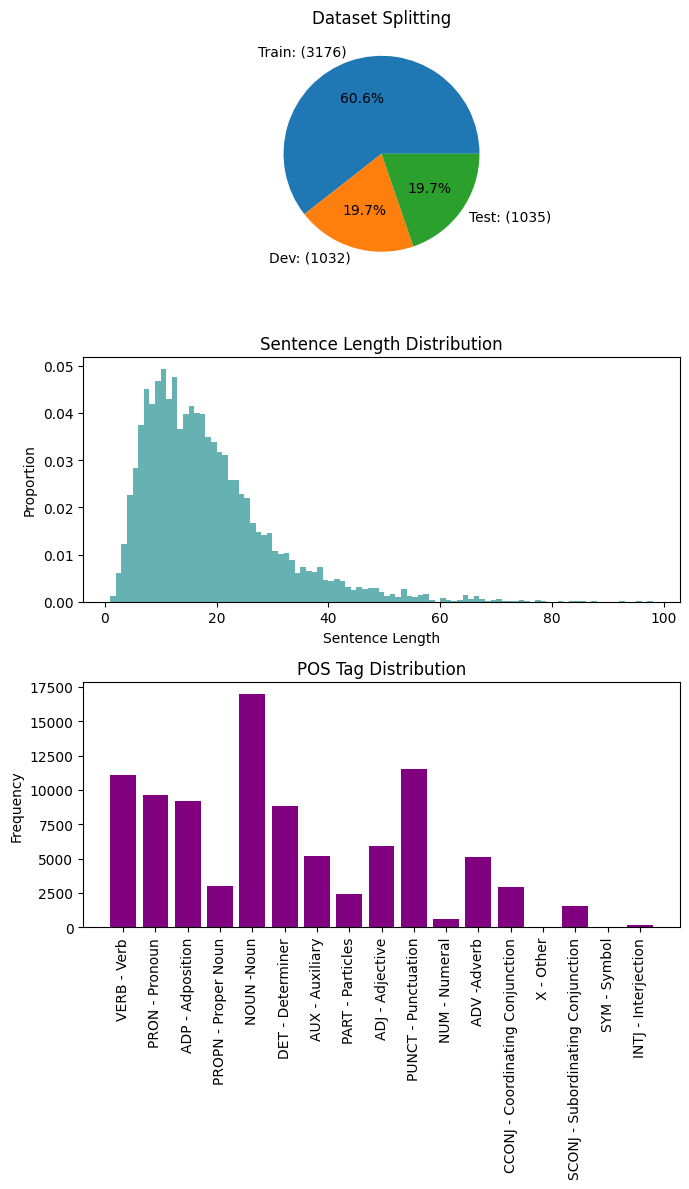

In [ ]:
# First plot
dataset = ['Train', 'Dev', 'Test']
lengths = [len(train_dataset), len(dev_dataset), len(test_dataset)]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 12))

# Pie chart
pie_labels = [f"{label}: ({length})" for label, length in zip(dataset, lengths)]
ax1.pie(lengths, labels=pie_labels, autopct='%1.1f%%')
ax1.set_title('Dataset Splitting')

# Second plot
sentences_len = [len(sentence) for sentence in train_dataset['tokens']] + [len(sentence) for sentence in dev_dataset['tokens']] + [len(sentence) for sentence in test_dataset['tokens']]

ax2.hist(sentences_len, bins=range(min(sentences_len), max(sentences_len) + 1, 1), alpha=0.6, color="teal", density=True, stacked=True)
ax2.set_xlabel("Sentence Length")
ax2.set_ylabel("Proportion")
ax2.set_title("Sentence Length Distribution")

# Third plot
pos_counts = {}

pos_marks = ['0',
    '1',
    '2',
    '3',
    '4',
    '5',
    '6',
    '7',
    '8',
    '9',
    '10',
    '11',
    '12',
    '14',
    '15',
    '16',
    '17']

pos_map = {
    0: 'NOUN -Noun',
    1: 'PUNCT - Punctuation',
    2: 'ADP - Adposition',
    3: 'NUM - Numeral',
    4: 'SYM - Symbol',
    5: 'SCONJ - Subordinating Conjunction',
    6: 'ADJ - Adjective',
    7: 'PART - Particles',
    8: 'DET - Determiner',
    9: 'CCONJ - Coordinating Conjunction',
    10: 'PROPN - Proper Noun',
    11: 'PRON - Pronoun',
    12: 'X - Other',
    14: 'ADV -Adverb',
    15: 'INTJ - Interjection',
    16: 'VERB - Verb',
    17: 'AUX - Auxiliary',
}


for s in train_dataset:
    for i, token in enumerate(s["tokens"]):
        pos_tag = s['upos'][i]
        if pos_tag in pos_counts:
            pos_counts[pos_tag] += 1
        else:
            pos_counts[pos_tag] = 1

for s in dev_dataset:
    for i, token in enumerate(s["tokens"]):
        pos_tag = s['upos'][i]
        if pos_tag in pos_counts:
            pos_counts[pos_tag] += 1
        else:
            pos_counts[pos_tag] = 1


for s in test_dataset:
    for i, token in enumerate(s["tokens"]):
        pos_tag = s['upos'][i]
        if pos_tag in pos_counts:
            pos_counts[pos_tag] += 1
        else:
            pos_counts[pos_tag] = 1

pos_tags, counts = zip(*pos_counts.items())
pos_names = [pos_map.get(pos_tag) for pos_tag in pos_tags]

ax3.bar(pos_marks, counts, color='purple')
#ax3.set_xlabel('POS Tags')
ax3.set_ylabel('Frequency')
ax3.set_xticks(np.arange(17))
ax3.set_xticklabels(pos_names, rotation=90)
ax3.set_title('POS Tag Distribution')

plt.tight_layout()
plt.show()


# Data set-up

We found that
preliminarily tokenizing our dataset was the most convenient option. Also, we accordingly modified the `'tokens'` and `'head'` keys of the dataset by adding ROOT and its head (-1) and added '`input_ids'` and `'word_ids'` features for each sample in the dataset.



In [ ]:
def is_projective(tree):
  for i in range(len(tree)):
    if tree[i] == -1:
      continue
    left = min(i, tree[i])
    right = max(i, tree[i])

    for j in range(0, left):
      if tree[j] > left and tree[j] < right:
        return False
    for j in range(left+1, right):
      if tree[j] < left or tree[j] > right:
        return False
    for j in range(right+1, len(tree)):
      if tree[j] > left and tree[j] < right:
        return False

  return True


def create_dict(dataset, threshold=3):
  dic = {}  # dictionary of word counts
  for sample in dataset:
    for word in sample['tokens']:
      if word in dic:
        dic[word] += 1
      else:
        dic[word] = 1



  map = {}
  map["<pad>"] = 0
  map["<unk>"] = 1

  next_indx = 2
  for word in dic.keys():
    if dic[word] >= threshold:
      map[word] = next_indx
      next_indx += 1

  return map

In [ ]:
model_name = "bert-base-multilingual-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast = True)

In [ ]:
def tokenization(sample):
  sample['tokens'].insert(0, 'ROOT')
  sample['head'].insert(0, '-1')

  tokenized_sample = tokenizer(sample['tokens'], is_split_into_words = True, padding='max_length', max_length=120, truncation=True, return_tensors = 'pt')
  sample['input_ids'] = tokenized_sample['input_ids'][0]
  sample['word_ids'] = tokenized_sample.word_ids()

  return sample

In [ ]:
train_dataset = train_dataset.map(tokenization)
dev_dataset = dev_dataset.map(tokenization)
test_dataset = test_dataset.map(tokenization)

train_dataset = [sample for sample in train_dataset if is_projective([int(head) for head in sample["head"]])]

Map:   0%|          | 0/3176 [00:00<?, ? examples/s]

Map:   0%|          | 0/1032 [00:00<?, ? examples/s]

Map:   0%|          | 0/1035 [00:00<?, ? examples/s]

In [ ]:
emb_dictionary = create_dict(train_dataset)

In [ ]:
def process_sample(sample, get_gold_path = False, BERT = False):

  sentence = sample["tokens"]
  gold = [int(i) for i in sample["head"]]

  enc_sentence = [emb_dictionary[word] if word in emb_dictionary else emb_dictionary["<unk>"] for word in sentence]

  gold_path = []
  gold_moves = []

  if get_gold_path:
    parser = ArcEager(sentence)
    oracle = Oracle(parser, gold)

    while not parser.is_tree_final():
      if len(parser.stack) == 1:
        configuration = [-1, parser.stack[len(parser.stack)-1], parser.buffer[0]]
      else:
        configuration = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1], parser.buffer[0]]

      gold_path.append(configuration)


      if oracle.is_left_arc_gold():
        gold_moves.append(0)
        parser.left_arc()
      elif oracle.is_right_arc_gold():
        parser.right_arc()
        gold_moves.append(1)
      elif oracle.is_reduce_gold():
        parser.reduce()
        gold_moves.append(2)
      elif oracle.is_shift_gold():
        parser.shift()
        gold_moves.append(3)

  if BERT == False:
    return enc_sentence, gold_path, gold_moves, gold
  else:
    return enc_sentence, gold_path, gold_moves, gold, sample['input_ids'], sample['word_ids']

In [ ]:
def prepare_batch(batch_data, get_gold_path=False, BERT = False):
  data = [process_sample(s, get_gold_path=get_gold_path, BERT = BERT) for s in batch_data]
  sentences = [s[0] for s in data]
  paths = [s[1] for s in data]
  moves = [s[2] for s in data]
  trees = [s[3] for s in data]

  if BERT == False:

    return sentences, paths, moves, trees

  else:

    input_ids = [s[4] for s in data]
    word_ids = [s[5] for s in data]

    return sentences, paths, moves, trees, input_ids, word_ids

The evaluation metric used is UAS (unlabeled attachment score), which is the ratio of input words attached to the correct head, independently from the dependency label.

In [ ]:
def evaluate(gold, preds):
  total = 0
  correct = 0

  for g, p in zip(gold, preds):
    for i in range(1,len(g)):
      total += 1
      if g[i] == p[i]:
        correct += 1

  return correct/total

In [ ]:
def evaluate_BERT(gold, preds):
  total = 0
  correct = 0
  wrong_non_proj = 0 # we want to count how many non-projective tree we have parsed wrongly
  non_proj = 0       # we want to count how many non-projective tree there are
  wrong_ind = []

  for n, g, p in zip((range(len(gold))),gold,preds):

    found_non_proj = False
    found_wrong = False
    already_checked = False

    if not is_projective(g):
      found_non_proj = True
      non_proj += 1

    for i in range(1,len(g)):
      total += 1

      if g[i] == p[i]:
        correct += 1

      else:
        if not already_checked:
          found_wrong = True
          wrong_ind.append(n)

          if found_non_proj:
              wrong_non_proj +=1

          already_checked = True

  return correct/total, wrong_non_proj, non_proj, wrong_ind


# Bi-LSTM model

The following model exploits Bi-LSTMs ability to capture global dependencies and patterns to extract features from the embedded input sentences. The instrinsic peculiarity of Bi-LSTM is the capacity of grasping information from both forward and backwards contexts, thus obtaining a comprehensive contextual representation of each word.

The Bi-LSTM's output is then used to set out the demanded input for `mlp` (a multi-layer perceptron) that requires the concatenations of the vectors according to a certain feature function.

Note that we have tried a ($s_1$, $b_1$) configuration as the ArcEager parser only operates on the last stack element and the first buffer element, but eventually using this feature function ($s_2$, $s_1$, $b_1$) proved to perform better.

Such input is then fed into the `mlp` that, through the softmax function, will generate a vector of dimension 4 containing the score of each possible transition operator.

At inference time, the output of mlp is then used to concretely perform one of the transitions (the highest scoring move). In case some preconditions aren't met, the second highest scoring move is performed.


In [ ]:
wandb.init(
    project="ArcEager_NLP",

    config={
    "learning_rate": 0.005,
    "architecture": "BiLSTM",
    "epochs": 15,
    "DROPOUT" : 0.3,
    "act_function": "Tanh"
    "BATCH_SIZE": 32
    }
)

config = wandb.config

wandb: Currently logged in as: erica-marras (marrpap). Use `wandb login --relogin` to force relogin


In [ ]:
EMBEDDING_SIZE = 200
LSTM_SIZE = 200
LSTM_LAYERS = 1
MLP_SIZE = 200
DROPOUT = config.DROPOUT
EPOCHS = config.epochs
LR = config.learning_rate

In [ ]:
class Net(nn.Module):

  def __init__(self, device):
    super(Net, self).__init__()
    self.device = device
    self.embeddings = nn.Embedding(len(emb_dictionary), EMBEDDING_SIZE, padding_idx=emb_dictionary["<pad>"])

    # initialize bi-LSTM
    self.lstm = nn.LSTM(EMBEDDING_SIZE, LSTM_SIZE, num_layers = LSTM_LAYERS, bidirectional=True, dropout=DROPOUT)

    # initialize feedforward
    self.w1 = torch.nn.Linear(6*LSTM_SIZE, MLP_SIZE, bias=True)
    self.activation = torch.nn.Tanh()
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)

    self.dropout = torch.nn.Dropout(DROPOUT)


  def forward(self, x, paths):
    x = [self.dropout(self.embeddings(torch.tensor(i).to(self.device))) for i in x]

    h = self.lstm_pass(x)

    # for each parser configuration that we need to score we arrange from the
    # output of the bi-lstm the correct input for the feedforward
    mlp_input = self.get_mlp_input(paths, h)

    # run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input)

    return out

  def lstm_pass(self, x):
    x = torch.nn.utils.rnn.pack_sequence(x, enforce_sorted=False)
    h, (h_0, c_0) = self.lstm(x)
    h, h_sizes = torch.nn.utils.rnn.pad_packed_sequence(h) # size h: (length_sentences, batch, output_hidden_units)
    return h

  def get_mlp_input(self, configurations, h):
    mlp_input = []
    zero_tensor = torch.zeros(2*LSTM_SIZE, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]:        # for each configuration of a sentence
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[j[0]][i], zero_tensor if j[1]==-1 else h[j[1]][i],zero_tensor if j[2]==-1 else h[j[2]][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  def infere(self, x):

    parsers = [ArcEager(i) for i in x]

    x = [self.embeddings(torch.tensor(i).to(self.device)) for i in x]

    h = self.lstm_pass(x)

    while not self.parsed_all(parsers):

      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h)
      mlp_out = self.mlp(mlp_input)
      self.parse_step(parsers, mlp_out)

    return [parser.arcs for parser in parsers]

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1, -1]
      elif len(parser.stack) == 1:
        conf = [-1, parser.stack[len(parser.stack)-1], parser.buffer[0]]
      else:
        conf = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1], parser.buffer[0]]
      configurations.append([conf])

    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True



  def parse_step(self, parsers, moves):
    moves_argm = moves.argmax(-1)
    for i in range(len(parsers)):

      if parsers[i].is_tree_final():
        continue

      else:
        softmoves = moves[i]
        ## left_arc ##
        if moves_argm[i] == 0:

          if not parsers[i].left_arc():
          # if preconditions aren't met

            if parsers[i].stack[-1] == 0: # the last element of the stack is the ROOT

              # can't reduce the ROOT, so only 2 options:

              if softmoves[3] > softmoves[1]:
                parsers[i].shift()
              else:
                parsers[i].right_arc()

            else: # the last element of the stack already has a head

              if softmoves[1] > softmoves[2] and softmoves[1] > softmoves[3]:
                parsers[i].right_arc()
              elif softmoves[2] > softmoves[3]:
                parsers[i].reduce()
              else:
                parsers[i].shift()


        ## right_arc ##
        elif moves_argm[i] == 1:

            parsers[i].right_arc()

        ## reduce ##
        elif moves_argm[i] == 2:

            if not parsers[i].reduce():
            # the last element of the stack doesn't have a head
              if softmoves[0] > softmoves[1] and softmoves[0] > softmoves[3]:
                if not parsers[i].left_arc():
                  if softmoves[1] > softmoves[3]:
                    parsers[i].right_arc()
                  else:
                    parsers[i].shift()

              elif softmoves[1] > softmoves[3]:
                parsers[i].right_arc()


              else:
                parsers[i].shift()


        ## shift ##
        elif moves_argm[i] == 3:

            parsers[i].shift()

## Train and Test

In [ ]:
BATCH_SIZE = config.BATCH_SIZE

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch, get_gold_path=True))
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))

In [ ]:
def train(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  count = 0


  for batch in dataloader:

    optimizer.zero_grad()
    sentences, paths, moves, trees = batch

    out = model(sentences, paths)
    labels = torch.tensor(sum(moves, [])).to(device) #sum(moves, []) flatten the array
    loss = criterion(out, labels)

    count +=1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()


  return total_loss/count

def test(model, dataloader):
  model.eval()

  gold = []
  preds = []


  for batch in dataloader:


    sentences, paths, moves, trees = batch
    with torch.no_grad():

      pred = model.infere(sentences)

      gold += trees
      preds += pred


  return evaluate(gold, preds)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model = Net(device)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

for epoch in range(EPOCHS):
  avg_train_loss = train(model, train_dataloader, criterion, optimizer)
  val_uas = test(model, dev_dataloader)

  wandb.log({"avg_train_loss": avg_train_loss, "val_uas": val_uas})


  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch + 1, avg_train_loss, val_uas))

Device: cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch:   1 | avg_train_loss: 0.986 | dev_uas: 0.624 |
Epoch:   2 | avg_train_loss: 0.905 | dev_uas: 0.655 |
Epoch:   3 | avg_train_loss: 0.883 | dev_uas: 0.668 |
Epoch:   4 | avg_train_loss: 0.867 | dev_uas: 0.691 |
Epoch:   5 | avg_train_loss: 0.859 | dev_uas: 0.710 |
Epoch:   6 | avg_train_loss: 0.851 | dev_uas: 0.705 |
Epoch:   7 | avg_train_loss: 0.845 | dev_uas: 0.711 |
Epoch:   8 | avg_train_loss: 0.842 | dev_uas: 0.718 |
Epoch:   9 | avg_train_loss: 0.837 | dev_uas: 0.719 |
Epoch:  10 | avg_train_loss: 0.833 | dev_uas: 0.720 |
Epoch:  11 | avg_train_loss: 0.831 | dev_uas: 0.725 |
Epoch:  12 | avg_train_loss: 0.829 | dev_uas: 0.727 |
Epoch:  13 | avg_train_loss: 0.826 | dev_uas: 0.730 |
Epoch:  14 | avg_train_loss: 0.825 | dev_uas: 0.727 |
Epoch:  15 | avg_train_loss: 0.823 | dev_uas: 0.728 |


In [ ]:
test_uas = test(model, test_dataloader)
print("test_uas: {:5.3f}".format( test_uas))

wandb.log({"test_uas": test_uas})

test_uas: 0.737


In [ ]:
wandb.finish()

avg_train_loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁
test_uas,▁
val_uas,▁▃▅▅▆▆▇▇▇▇▇▇▇██
avg_train_loss,0.82329
test_uas,0.74297
val_uas,0.74032


# BERT model


The following model uses **BERT** (`'bert-base-multilingual-uncased'`) text encoder to obtain contextualized embeddings of input words (we summed the last 4 hidden layers). \
As mentioned before, we have tokenized the input sentences using a `FastTokenizer`: we have stored `'input_ids'` and `'word_ids'` for each sample in the dataset.
BERT will need `'input_ids'` to output the embeddings of the words in the sentences.\
Since BERT uses BPE tokenizer, unknown words are split into subtokens: we use `'word_ids'` to keep track of that so we can average the embeddings of the subtoken relatives to a certain word.
Once the subtokens have been handled, the implementation is the same as the Bi-LSTM model.
We have tried to use the hinge loss as presented during the course, but it did not cause significant improvements.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

BERT = AutoModel.from_pretrained(model_name).to(device)

Device: cuda


Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
wandb.init(
    project="ArcEager_NLP",

    config={
    "learning_rate": 0.001,
    "architecture": "BERT",
    "epochs": 15,
    "DROPOUT" : 0.2,
    "act_function": "LeakyReLU",
    "BATCH_SIZE": 32
    })

config = wandb.config

wandb: Currently logged in as: erica-marras (marrpap). Use `wandb login --relogin` to force relogin


In [ ]:
EMBEDDING_SIZE = 768
LSTM_SIZE = 200
LSTM_LAYERS = 1
MLP_SIZE = 200
DROPOUT = config.DROPOUT
EPOCHS = config.epochs
LR = config.learning_rate

In [ ]:
class BertParser(nn.Module):
  def __init__(self, device):
    super(BertParser, self).__init__()
    self.device = device

    # initialize FFN
    self.w1 = torch.nn.Linear(3*EMBEDDING_SIZE, MLP_SIZE, bias = True)
    self.activation = torch.nn.LeakyReLU()
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)

    self.dropout = torch.nn.Dropout(DROPOUT)


  def forward(self, input_ids, paths, word_ids):

    h = self.bert_pass(input_ids)

    mlp_input = self.get_mlp_input(paths, h, word_ids).to(self.device)

    out = self.mlp(mlp_input).to(self.device)

    return out


  def bert_pass(self, input_ids):

    input_ids = torch.tensor(input_ids).to(self.device)

    h = BERT(input_ids.to(self.device), output_hidden_states = True)

    h = torch.sum(torch.stack([h.hidden_states[-1], h.hidden_states[-2], h.hidden_states[-3], h.hidden_states[-4]]), dim = 0).to(self.device)

    return h


  def get_mlp_input(self, configurations, h, word_ids):
    mlp_input = []
    zero_tensor = torch.zeros(EMBEDDING_SIZE, requires_grad=False).to(self.device)

    for i in range(len(configurations)):

      word_i = np.array(word_ids[i])

      for j in configurations[i]:

        j_0 = np.where(word_i == j[0])[0]
        j_1 = np.where(word_i == j[1])[0]
        j_2 = np.where(word_i == j[2])[0]

        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else torch.mean(h[i][j_0], dim = 0), zero_tensor if j[1]==-1 else torch.mean(h[i][j_1], dim = 0), zero_tensor if j[2]==-1 else torch.mean(h[i][j_2], dim = 0)]))
    mlp_input = torch.stack(mlp_input).to(self.device)

    return mlp_input


  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  def infere(self, sentences_lst, input_ids, word_ids):

    parsers = [ArcEager(i) for i in sentences_lst]

    h = self.bert_pass(input_ids).to(self.device)

    pred_moves = [[] for _ in range(len(parsers))]

    while not self.parsed_all(parsers):
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h, word_ids).to(self.device)
      mlp_out = self.mlp(mlp_input).to(self.device)

      # take the next parsing step and save predicted moves
      pred_moves = self.parse_step(parsers, mlp_out, pred_moves)

    # return the predicted dependency tree and the predicted moves
    return [parser.arcs for parser in parsers], pred_moves


  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1, -1]
      elif len(parser.stack) == 1:
        conf = [-1, parser.stack[len(parser.stack)-1], parser.buffer[0]]
      else:
        conf = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1], parser.buffer[0]]
      configurations.append([conf])

    return configurations


  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True


  def parse_step(self, parsers, moves, pred_moves):

    moves_argm = moves.argmax(-1)

    for i in range(len(parsers)):

      if parsers[i].is_tree_final():
        continue

      else:
        softmoves = moves[i]

        ## left_arc ##
        if moves_argm[i] == 0:

          if not parsers[i].left_arc():  # if preconditions aren't met

            if parsers[i].stack[-1] == 0: # if the last element of the stack is the ROOT

              # can't reduce the ROOT, so only 2 options:

              if softmoves[3] > softmoves[1]:
                parsers[i].shift()
                pred_moves[i].append(3)
              else:
                parsers[i].right_arc()
                pred_moves[i].append(1)

            else: # the last element of the stack already has a head

              if softmoves[1] > softmoves[2] and softmoves[1] > softmoves[3]:
                parsers[i].right_arc()
                pred_moves[i].append(1)
              elif softmoves[2] > softmoves[3]:
                parsers[i].reduce()
                pred_moves[i].append(2)
              else:
                parsers[i].shift()
                pred_moves[i].append(3)
          else:
            pred_moves[i].append(0)



        ## right_arc ##
        elif moves_argm[i] == 1:
            parsers[i].right_arc()
            pred_moves[i].append(1)

        ## reduce ##
        elif moves_argm[i] == 2:


            if not parsers[i].reduce():
              # the last element of the stack doesn't have a head
              if softmoves[0] > softmoves[1] and softmoves[0] > softmoves[3]:
                if not parsers[i].left_arc():
                  if softmoves[1] > softmoves[3]:
                    parsers[i].right_arc()
                    pred_moves[i].append(1)
                  else:
                    parsers[i].shift()
                    pred_moves[i].append(3)
                else:
                  pred_moves[i].append(0)

              elif softmoves[1] > softmoves[3]:
                parsers[i].right_arc()
                pred_moves[i].append(1)


              else:
                parsers[i].shift()
                pred_moves[i].append(3)

            else:
              pred_moves[i].append(2)


        ## shift ##
        elif moves_argm[i] == 3:

            parsers[i].shift()
            pred_moves[i].append(3)

    return pred_moves



## Train and Test

In [ ]:
BATCH_SIZE = config.BATCH_SIZE

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch, get_gold_path=True, BERT = True))
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch, BERT = True))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch, BERT = True))

In [ ]:
def train_BERT(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  count = 0



  for batch in dataloader:

    optimizer.zero_grad()
    sentences_lst, paths, moves, trees, input_ids, word_ids = batch


    out = model(input_ids, paths, word_ids)
    labels = torch.tensor(sum(moves, [])).to(device) #sum(moves, []) flatten the array
    loss = criterion(out, labels)

    count +=1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()


  return total_loss/count

def test_BERT(model, dataloader):
  model.eval()

  gold = []
  preds = []


  pred_moves_BERT = [[] for _ in range(len(dataloader))]

  for i,batch in enumerate(dataloader):
    sentences_lst, paths, moves, trees, input_ids, word_ids = batch

    with torch.no_grad():
      pred, pred_moves = model.infere(sentences_lst, input_ids, word_ids)

      pred_moves_BERT[i] = pred_moves
      gold += trees
      preds += pred



  return evaluate_BERT(gold, preds), pred_moves_BERT

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model = BertParser(device)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


for epoch in range(EPOCHS):

  avg_train_loss = train_BERT(model, train_dataloader, criterion, optimizer)
  (val_uas, wrong_non_proj, non_proj, wrong_ind), pred_moves_BERT = test_BERT(model, dev_dataloader)


  wandb.log({"avg_train_loss": avg_train_loss, "val_uas": val_uas})


  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format(epoch+1, avg_train_loss, val_uas))

Device: cuda
Epoch:   1 | avg_train_loss: 1.034 | dev_uas: 0.665 |
Epoch:   2 | avg_train_loss: 0.874 | dev_uas: 0.766 |
Epoch:   3 | avg_train_loss: 0.853 | dev_uas: 0.780 |
Epoch:   4 | avg_train_loss: 0.842 | dev_uas: 0.794 |
Epoch:   5 | avg_train_loss: 0.834 | dev_uas: 0.788 |
Epoch:   6 | avg_train_loss: 0.829 | dev_uas: 0.813 |
Epoch:   7 | avg_train_loss: 0.823 | dev_uas: 0.812 |
Epoch:   8 | avg_train_loss: 0.820 | dev_uas: 0.821 |
Epoch:   9 | avg_train_loss: 0.815 | dev_uas: 0.827 |
Epoch:  10 | avg_train_loss: 0.812 | dev_uas: 0.829 |
Epoch:  11 | avg_train_loss: 0.809 | dev_uas: 0.825 |
Epoch:  12 | avg_train_loss: 0.808 | dev_uas: 0.830 |
Epoch:  13 | avg_train_loss: 0.807 | dev_uas: 0.835 |
Epoch:  14 | avg_train_loss: 0.802 | dev_uas: 0.837 |
Epoch:  15 | avg_train_loss: 0.801 | dev_uas: 0.834 |


In [ ]:
(test_uas, wrong_non_proj, non_proj, wrong_ind), pred_moves_BERT = test_BERT(model, test_dataloader)


print("test_uas: {:5.3f}".format( test_uas))

wandb.log({"test_uas": test_uas})

test_uas: 0.845


In [ ]:
wandb.finish()

avg_train_loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁
test_uas,▁
val_uas,▁▄▅▆▆▆▇▆▇▇█████
avg_train_loss,0.80245
test_uas,0.84175
val_uas,0.83349


# Comparison between two models

We have tried different parameters for both models:
* Activation function in `mlp` = [tanh, ReLU, LeakyReLU]
* lr = [0.001, 0.003, 0.005]
* DROPOUT = [0.1, 0.2, 0.3]

The best parameters are the ones used in the model tested in the notebook, other configurations are visible [here](https://wandb.ai/marrpap/ArcEager_NLP?workspace=user-erica-marras).

We are only going to display only a few comparisons, keeping one parameter fixed at the time.
In general, no matter the choice of parameters, the model that used the BERT encoder performs significantly better: the avg_train_loss of the BERT model is constanly below the Bi-LSTM one. Coherently, BERT's val_aus and test_aus are generally about 0.1 higher.

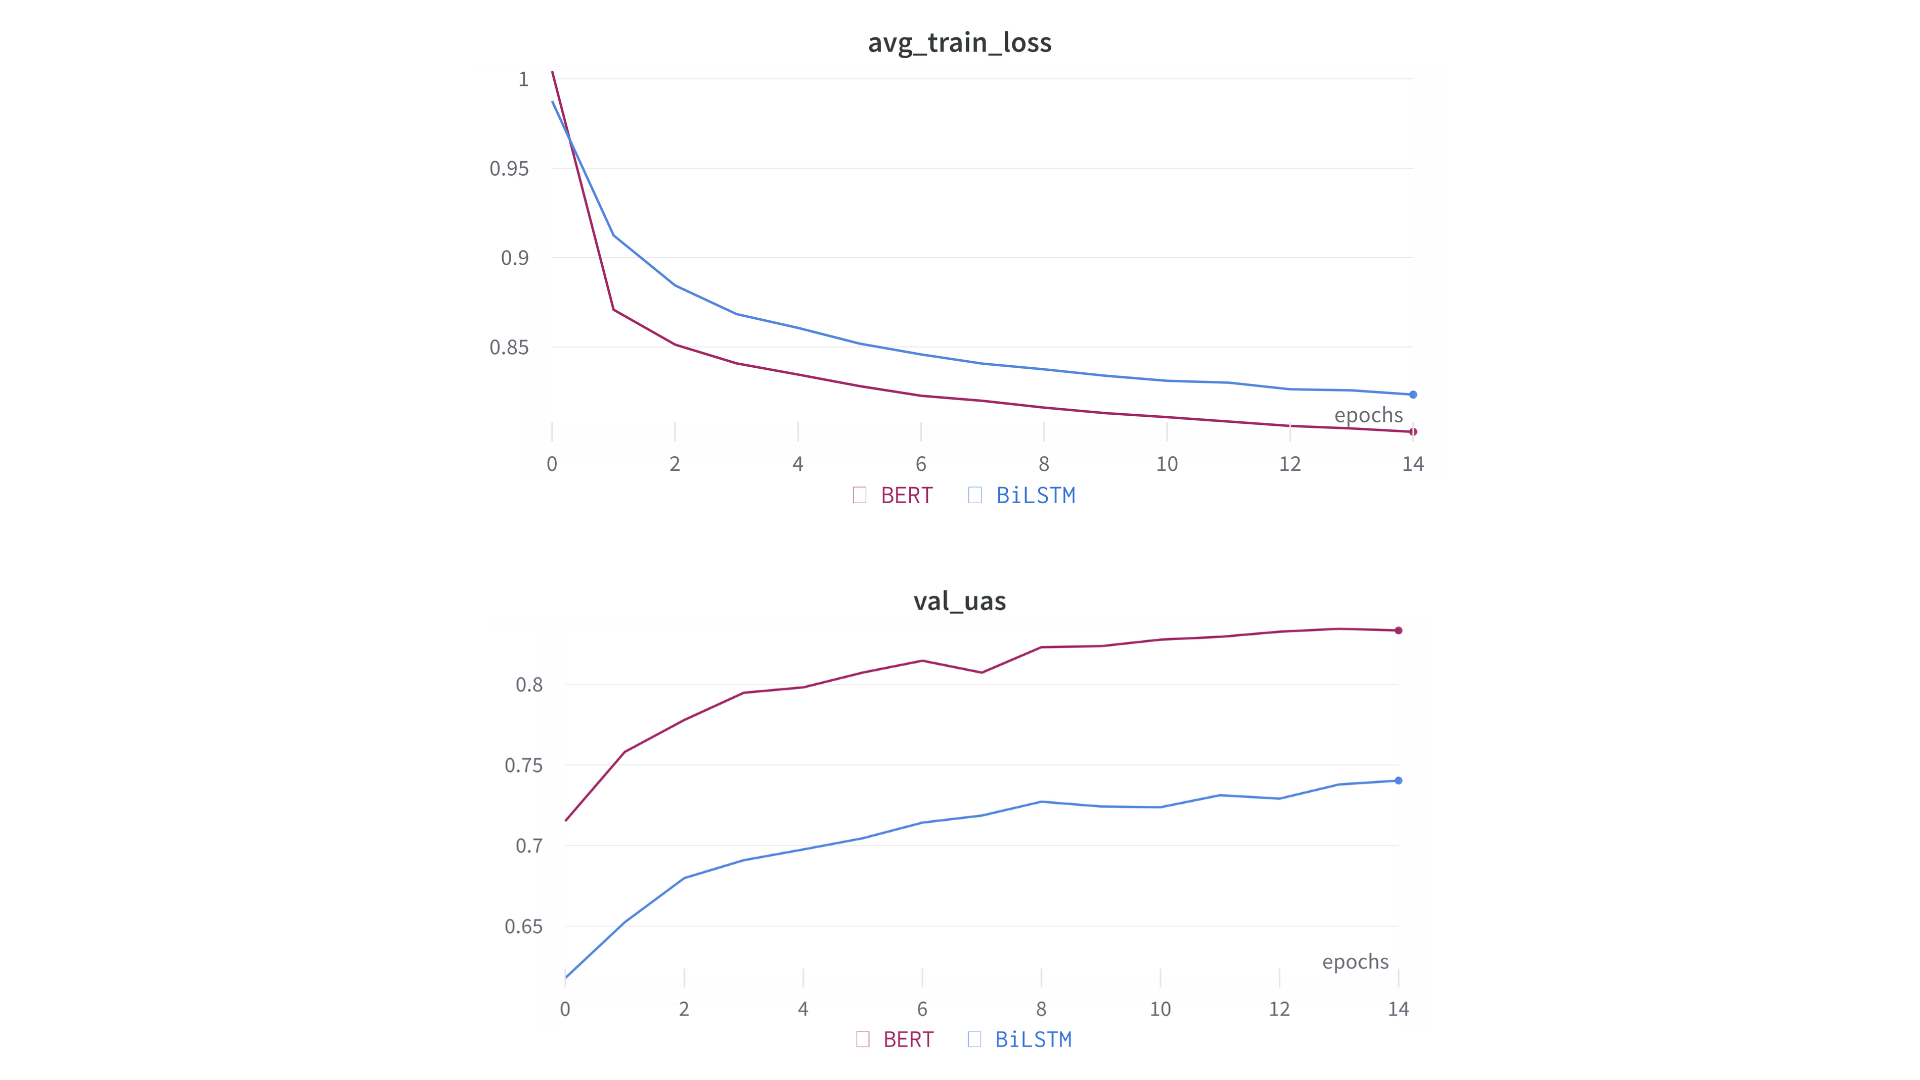

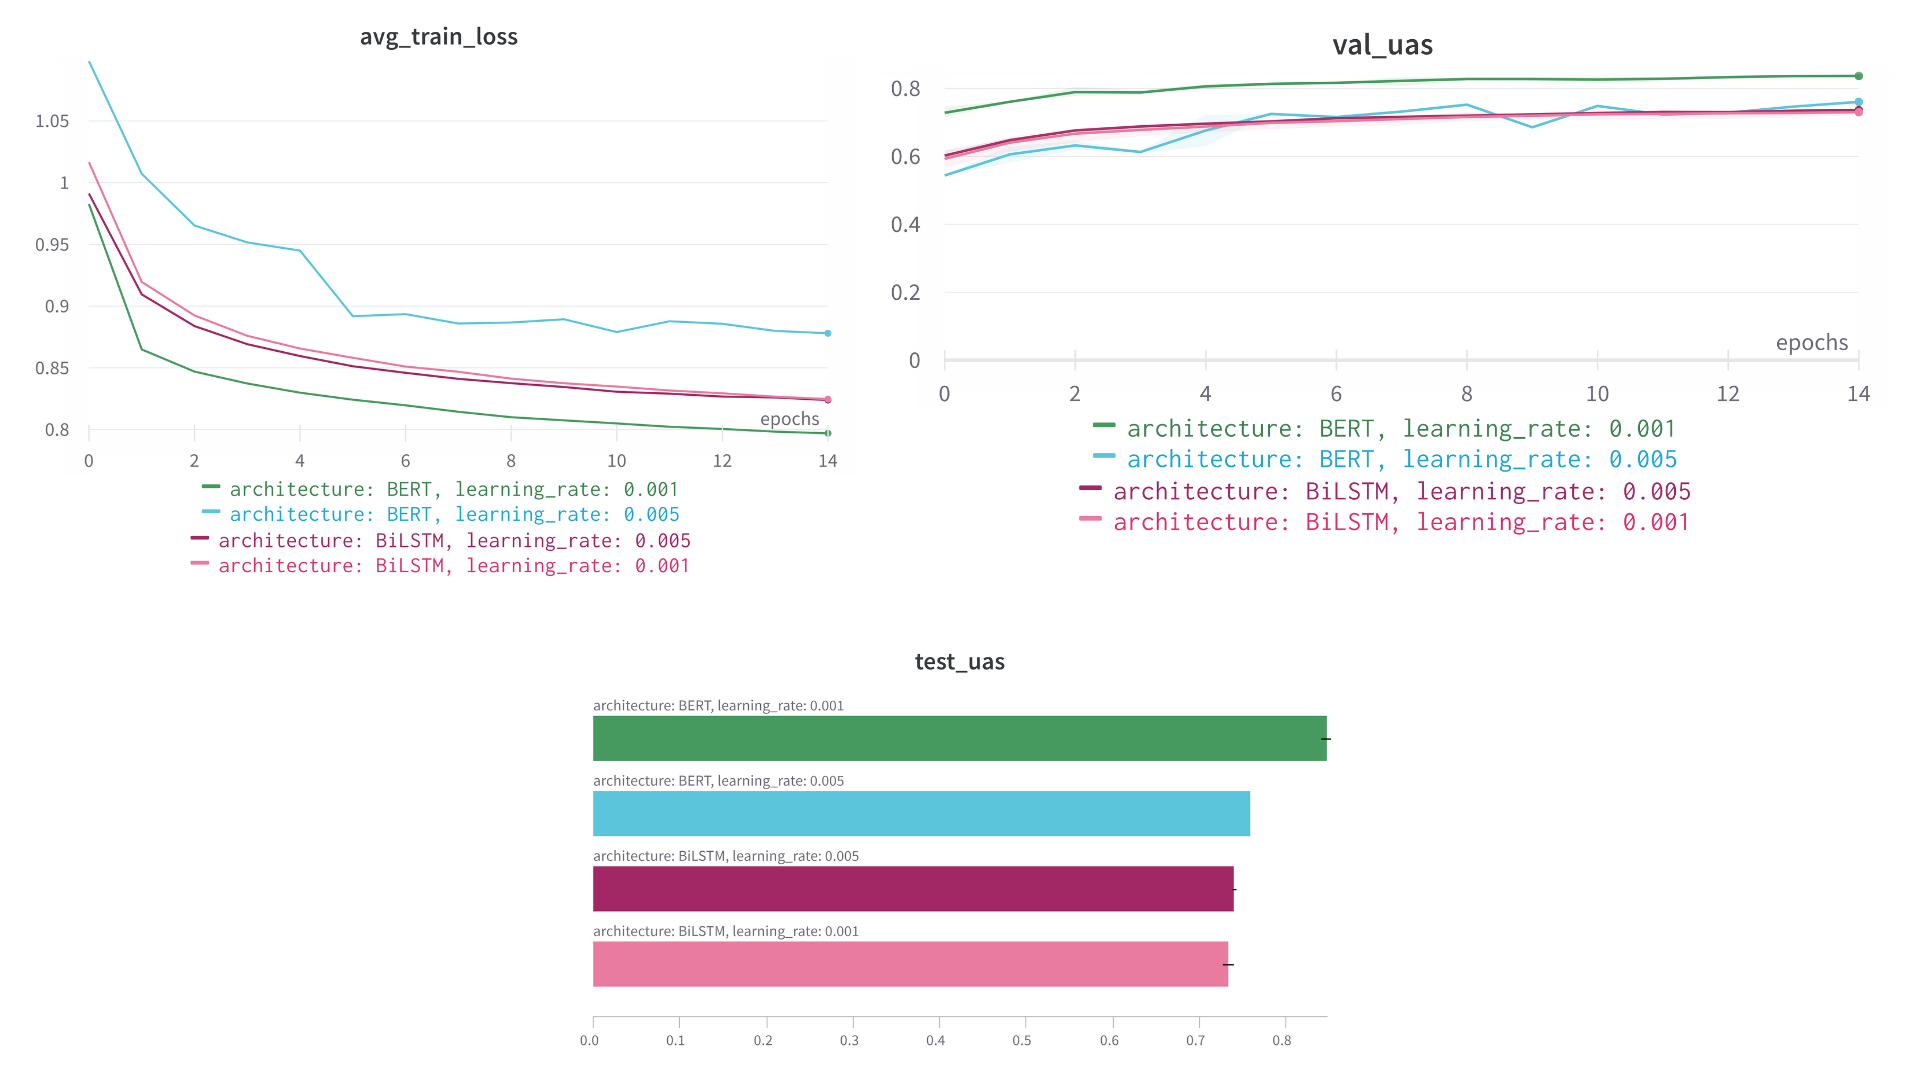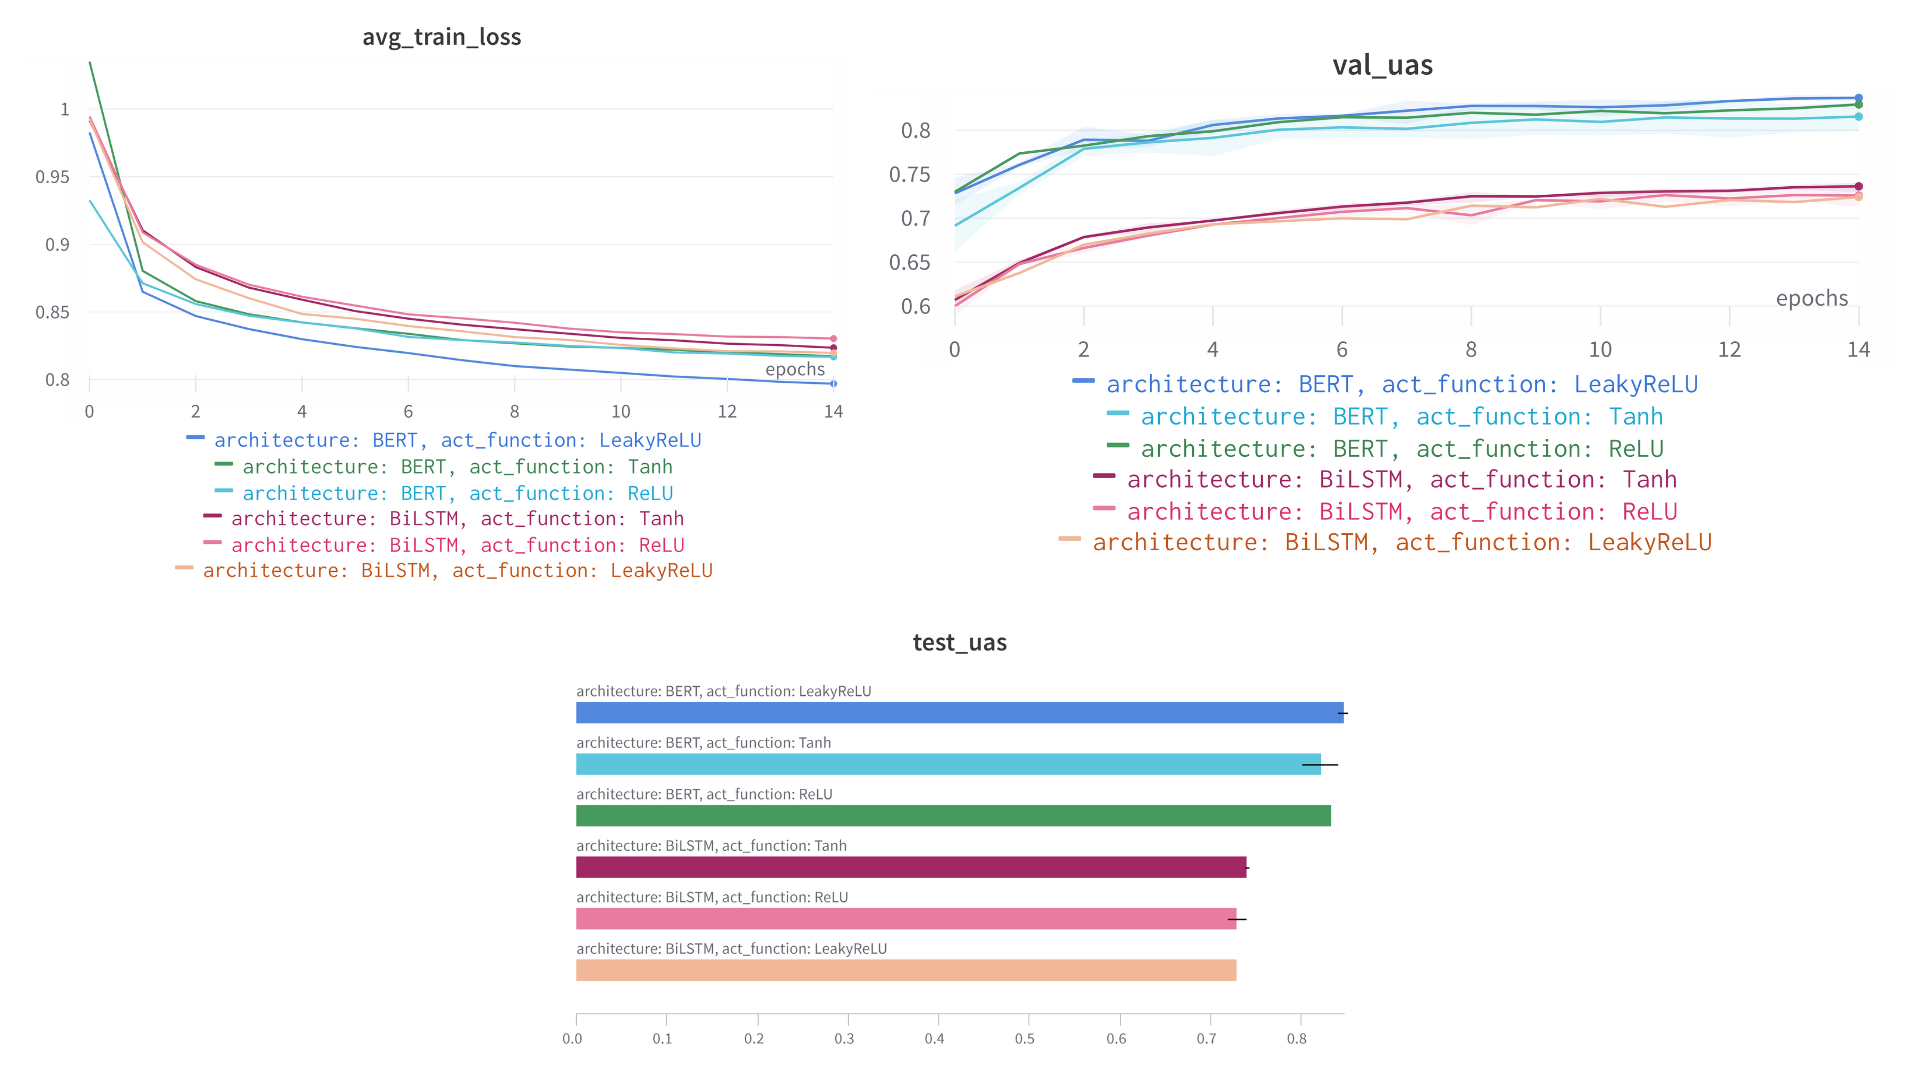

# Error Analysis

In [ ]:
print("The number of wrongly parsed trees is ", len(wrong_ind))

The number of wrongly parsed trees is  676


In [ ]:
for i, sample in enumerate(test_dataloader):
   if i in wrong_ind:
     wrong_sentences = sample[0]
   break

def get_keys_by_value(dictionary, value):
     keys = []
     for val in value:
       for k, v in dictionary.items():
         if v == val:
             keys.append(k)
     return keys

j = 9
get_keys_by_value(emb_dictionary, wrong_sentences[j])

['ROOT',
 'My',
 'father',
 'too',
 ',',
 'was',
 'still',
 '<unk>',
 ',',
 'strong',
 'and',
 '<unk>',
 ',',
 'as',
 'wide',
 'as',
 'he',
 'was',
 'tall',
 ',',
 'with',
 'an',
 '<unk>',
 '<unk>',
 'that',
 'looked',
 'as',
 'though',
 'it',
 'could',
 '<unk>',
 'the',
 '<unk>',
 '<unk>',
 'itself',
 '.']

In [ ]:
print('All the non-projective trees have been parsed wrongly:', non_proj == wrong_non_proj)

All the non-projective trees have been parsed wrongly: True


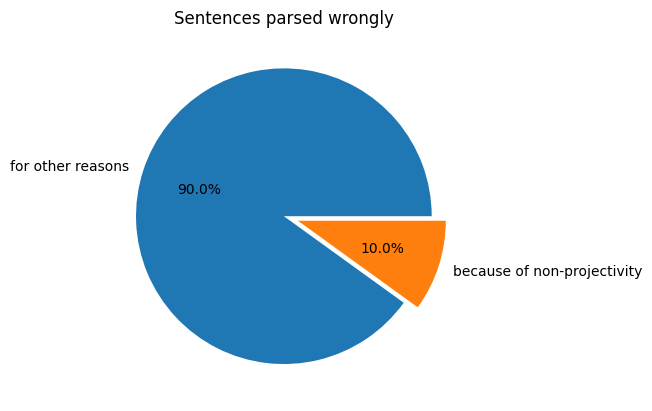

In [ ]:
labels = 'for other reasons', 'because of non-projectivity'
sizes = [len(wrong_ind) - wrong_non_proj, wrong_non_proj]
explode = (0, 0.1)

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', explode=explode)
ax.set_title('Sentences parsed wrongly')
fig.show()

In [ ]:
test_dataset_non_proj = [] # New test_dataset without non-projective samples
indexes_non_proj = []      # Indexes of non-projective samples

for i,sample in enumerate(test_dataset):
  if is_projective([int(head) for head in sample["head"]]):
    test_dataset_non_proj.append(sample)
  else:
    indexes_non_proj.append(i)

print('Length of original test dataset:', len(test_dataset))
print('Length of new test dataset without non-projective samples:', len(test_dataset_non_proj))

test_dataloader_non_proj = torch.utils.data.DataLoader(test_dataset_non_proj, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch, get_gold_path=True, BERT = True))

Length of original test dataset: 1035
Length of new test dataset without non-projective samples: 968


In [ ]:
gold_moves_flattened = []
for b in test_dataloader_non_proj:
  gold_moves_flattened = gold_moves_flattened + b[2]


pred_moves_BERT_flattened = []
for i in pred_moves_BERT:
  pred_moves_BERT_flattened = pred_moves_BERT_flattened + i


pred_moves_flattened = []

for i,m in enumerate(pred_moves_BERT_flattened):
  if i in indexes_non_proj:
    continue
  else:
    pred_moves_flattened.append(m)

print('check the length:', len(gold_moves_flattened) == len(pred_moves_flattened))

check the length: True


Text(0, 0.5, 'True Label')

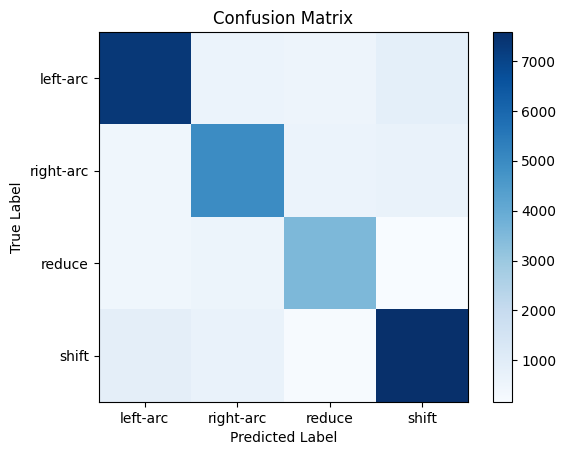

In [ ]:
M = torch.zeros(4, 4)

for i, j in zip(gold_moves_flattened, pred_moves_flattened):
  min_length = min(len(i), len(j))
  M += confusion_matrix(i[0:min_length], j[0:min_length], labels=[0, 1, 2, 3])


class_labels = ['left-arc', 'right-arc', 'reduce', 'shift']

# Plot confusion matrix
plt.imshow(M, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=0)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [ ]:
M = np.array(M)

num_labels = M.shape[0]

accuracy = np.zeros(num_labels)
precision = np.zeros(num_labels)
recall = np.zeros(num_labels)


for i in range(num_labels):
    TP = M[i, i]
    TN = np.sum(M) - (np.sum(M[i, :]) + np.sum(M[:, i]) - TP)
    FP = np.sum(M[:, i]) - TP
    FN = np.sum(M[i, :]) - TP

    accuracy[i] = (TP + TN) / (TP + TN + FP + FN)

    precision[i] = TP / (TP + FP)

    recall[i] = TP / (TP + FN)

for i in range(num_labels):
    print("Class:", class_labels[i])
    print("Accuracy: ", accuracy[i])
    print("Precision:", precision[i])
    print("Recall:   ", recall[i])
    print("___________________________")

Class: left-arc
Accuracy:  0.8739506951126448
Precision: 0.8041835505421093
Recall:    0.7850117596750054
___________________________
Class: right-arc
Accuracy:  0.8802548193370716
Precision: 0.7271528998242531
Recall:    0.739830129637908
___________________________
Class: reduce
Accuracy:  0.9151597597796874
Precision: 0.7191947946319642
Recall:    0.7504774029280713
___________________________
Class: shift
Accuracy:  0.8848999635024387
Precision: 0.8180738501403585
Recall:    0.8094220702916355
___________________________


The number of wrongly parsed trees is 676. By looking at some sentences that were not parser correctly (as the one printed above), we could find a pattern in just a few of them: they are mostly sentences with parenthetic elements or with distant dependencies.

We were expecting that the presence of non projective trees in the test set could cause some problems in the parsing task: indeed, the entirety of non projective trees were wrongly parsed, even in this case only constitutes the 10% of the all wrongly parsed trees.
The presented confusion matrix helps summarizing the classification of every transition operator during parsing.
The transition with the highest accuracy is `Reduce`, while the transition operator with the highest precision is `Shift`: this implies that out of all the `Shift` predictions, 81% of them were actually correct. On the other hand, `RightArc` is the operator with the lowest recall: the model was able to predict correctly only the 73% of the actual positive instances.

# SoTA


**LEADERBOARD**

|    | Model   | UAS   |
|---|---|---|
| 1 | UDify | 87.33   |
| 2 |  UDPipe 2.0 with WE+CLE+BERT+Flair where available | 87.28    |
| 3 |  UDPipe |   84.17  |
| 4 |  UDPipe 2.0 with WE+CLE |   84.15  |
| 5 |  UDPipe 2.0 prototype in CoNLL 2018 UD Shared Task|   82.73  |


The State-of-The-Art for the unlabeled dependecy parsing task (evaluated using UAS) is the model [UDify](https://arxiv.org/pdf/1904.02099v3.pdf)
that consists of a multilingual (104 languages) multi-task BERT text enconder trained on all available datasets concatenated together. Information about the other models in the leaderboard is available at https://aclanthology.org/K18-2020.pdf and https://arxiv.org/pdf/1908.07448v1.pdf.
